# Energy Consumption Forecast using XGBoost Algorithm

### About the data 
**This dataset is from Kaggle**

**PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [261]:
df = pd.read_csv("PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [262]:
# Verifying the data type
df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

**Datetime columns is object type, changing it to datetime type and setting the Datetime column as the index**

In [263]:
#df["Datetime"] = pd.to_datetime(df["Datetime"])
#df.dtypes

In [264]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Verifying if the dataset is properly ordered by dates in ascending order

In [265]:
print("The earliest date is:", df.index.min())

The earliest date is: 2002-01-01 01:00:00


**Sorting the data in ascending order to ensure proper chronological splitting for training and testing**

In [266]:
# Ensure the DataFrame is sorted by datetime index
df = df.sort_index()
df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


**Visualizing the data**

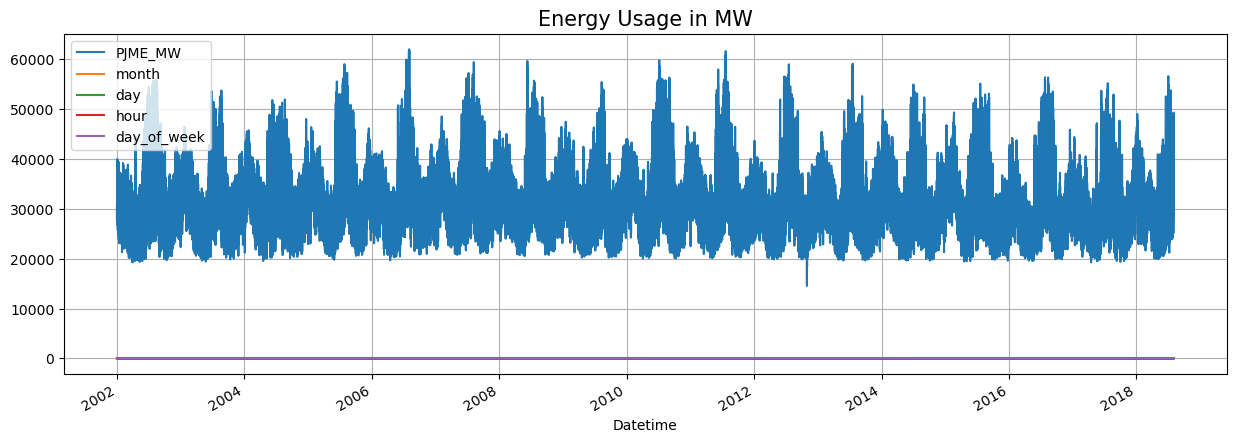

In [270]:
df.plot(figsize=(15,5))
plt.title("Energy Usage in MW", fontsize=15)
plt.grid(True)
plt.show()

## Feature engineering

**Crearing new inputs from raw data**

In [271]:
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df.head()

,PJME_MW,month,day,hour,day_of_week
Datetime,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1
2002-01-01 02:00:00,29265.0,1,1,2,1
2002-01-01 03:00:00,28357.0,1,1,3,1
2002-01-01 04:00:00,27899.0,1,1,4,1
2002-01-01 05:00:00,28057.0,1,1,5,1


## Splitting the dataset into Train and Test sets

**Creating features and labels**

In [272]:
X = df.drop("PJME_MW", axis=1)
y = df["PJME_MW"]

In [273]:
# Showing the features
X_train.head()

,month,day,hour,day_of_week
Datetime,,,,
2002-01-01 01:00:00,1,1,1,1
2002-01-01 02:00:00,1,1,2,1
2002-01-01 03:00:00,1,1,3,1
2002-01-01 04:00:00,1,1,4,1
2002-01-01 05:00:00,1,1,5,1


In [274]:
# Showring the labels which is the actual consumption of energy
pd.DataFrame(y).head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


**Function to split the data into train and test sets**

In [275]:
def split_data(features, labels, percent=80):

    # Splitting the data into features, labels, train and test sets
    split = int(percent/100 * len(features))
    
    X = features
    y = labels
    
    X_train = X.iloc[:split]
    y_train = y.iloc[:split]
    
    X_test = X.iloc[split:]
    y_test = y.iloc[split:]

    return X_train, y_train, X_test, y_test

In [276]:
# Splitting the dataset in to 80% for training and 20% for testing
X_train, y_train, X_test, y_test = split_data(X, y, 80)

In [277]:
print("Lend of training set:", len(X_train))
print("Lend of testing set:", len(X_test))

Lend of training set: 116292
Lend of testing set: 29074


In [278]:
pd.DataFrame(y_train)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2015-04-09 10:00:00,33082.0
2015-04-09 11:00:00,33285.0
2015-04-09 12:00:00,33148.0


In [279]:
pd.DataFrame(y_test).head()

,PJME_MW
Datetime,
2015-04-09 15:00:00,32204.0
2015-04-09 16:00:00,32049.0
2015-04-09 17:00:00,32209.0
2015-04-09 18:00:00,32707.0
2015-04-09 19:00:00,33012.0


## Plotting energy consumption for training and test sets

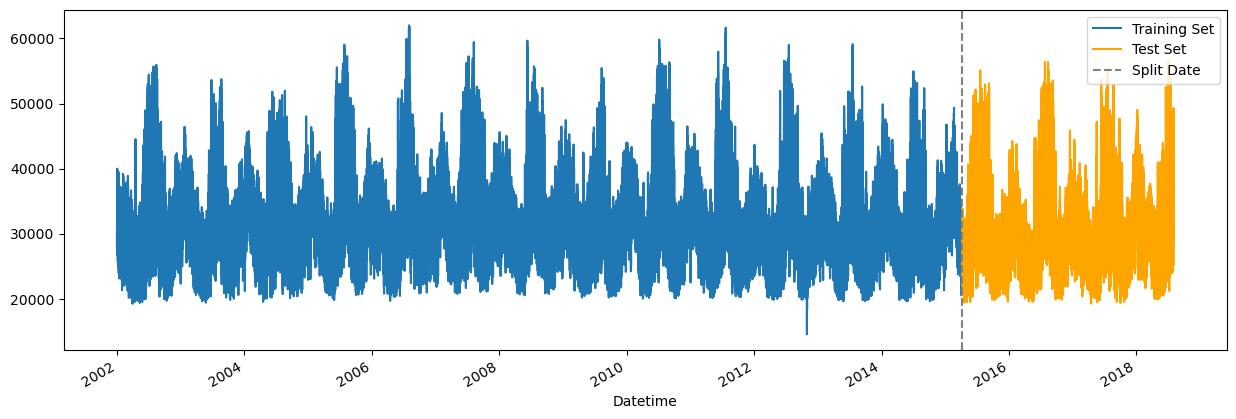

In [280]:
# Plot the training and test sets
date_of_split = "2015-04-09 14:00:00"

fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label="Training Set")
y_test.plot(ax=ax, label="Test Set", color="orange")
ax.axvline(date_of_split, ls="--", color="gray", label="Split Date")
ax.legend()
plt.show()